<a href="https://colab.research.google.com/github/Jungin1020/Aiffel_exp/blob/main/2022_01_18_exp_5_kaggle_myself_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_dir = '/content/drive/MyDrive/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [4]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
y = train['price']
del train['price']
del train['id']
test.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [6]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

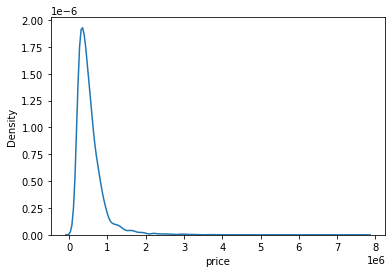

In [7]:
sns.kdeplot(y)
plt.show()

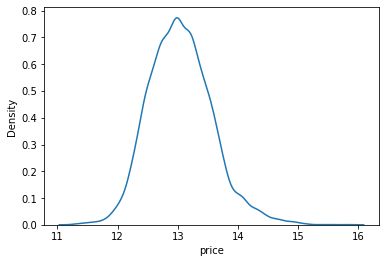

In [8]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

##mean_squared_error 손실함수 사용

In [10]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [11]:
def rmse(y_test,y_pred):
  return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [12]:
rs=2020

gboost = GradientBoostingRegressor(random_state=rs)
xgboost = XGBRegressor(random_state=rs)
lightgbm = LGBMRegressor(random_state=rs)
rdforest = RandomForestRegressor(random_state=rs)

models = [gboost, xgboost, lightgbm, rdforest]

##learning rate, max_depth, nrounds 등 파라미터를 적용해 보았지만 디폴트 값이 제일 좋아서 다 뺐다.

In [13]:
def get_scores(models, train, y):
  df = {}
  for model in models:
    model_name = model.__class__.__name__
    X_train,X_test,y_train,y_test = train_test_split(train,y, random_state=rs,test_size=0.2)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    df[model_name] = rmse(y_test,y_pred)
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE',ascending=False)

  return score_df

In [14]:
get_scores(models, train, y)

[04:40:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
XGBRegressor,131067.446228
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [26]:
#########################################################################################################
param_grid = {
    'n_estimators': range(300,401,10),
    'max_depth':range(8,15,2),
    'learning_rate':[0.03,0.04,0.05,0.06,0.07,0.08],
    'boosting_type':['gbdt'],
    'max_leaf_nodes':range(5,101,5)
}

#그리드서치

In [17]:
# def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
#   model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error',cv=5, verbose=verbose, n_jobs=n_jobs)

#   grid_model.fit(train,y)

#   params = grid_model.cv_results_['params']
#   score = grid_model.cv_results_['mean_test_score']

#   results = pd.DataFrame(params)
#   results['score'] = score
#   results['RMSLE'] = np.sqrt(-1*results['score'])
#   results = results.sort_values('RMSLE')

#   return results

In [18]:
#########################################################################################################
# model = LGBMRegressor(random_state=rs)
# grid_model = GridSearchCV(model,param_grid=param_grid, scoring='neg_mean_squared_error',cv=5, verbose=1, n_jobs=5)
# my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

#랜덤서치

In [27]:
def my_RandomSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
  #model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error',cv=5, verbose=verbose, n_jobs=n_jobs)
  mdoel = RandomizedSearchCV(model, param_distributions=param_grid, scoring='neg_mean_squared_error',cv=5, verbose=verbose, n_jobs=n_jobs)
  grid_model.fit(train,y)

  params = grid_model.cv_results_['params']
  score = grid_model.cv_results_['mean_test_score']

  results = pd.DataFrame(params)
  results['score'] = score
  results['RMSLE'] = np.sqrt(-1*results['score'])
  results = results.sort_values('RMSLE')
  results.head()

  return results

#trial_1_0.161341

In [28]:
#########################################################################################################
model = LGBMRegressor(random_state=rs)
grid_model = RandomizedSearchCV(model,param_grid, scoring='neg_mean_squared_error',cv=5, verbose=1, n_jobs=5)
my_RandomSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,n_estimators,max_leaf_nodes,max_depth,learning_rate,boosting_type,score,RMSLE
4,400,100,14,0.07,gbdt,-0.026031,0.161341
8,330,45,10,0.08,gbdt,-0.026053,0.161408
3,370,20,8,0.06,gbdt,-0.026085,0.161508
2,300,25,8,0.08,gbdt,-0.026099,0.161553
0,360,90,14,0.05,gbdt,-0.026200,0.161863
7,390,35,10,0.04,gbdt,-0.026265,0.162065
9,310,35,10,0.05,gbdt,-0.026270,0.162080
1,350,30,12,0.04,gbdt,-0.026332,0.162270
6,350,45,12,0.03,gbdt,-0.026732,0.163499
5,310,70,8,0.03,gbdt,-0.027043,0.164447


In [29]:
#########################################################################################################
param_grid = {
    'n_estimators': range(300,501,10),
    'max_depth':range(8,21),
    'learning_rate':[0.06,0.07,0.08,0.09,0.1],
    'boosting_type':['gbdt'],
    'max_leaf_nodes':range(5,150,5)
}


#trial_2_0.161025

## 편차가 조금 낮아졌다

In [30]:
#########################################################################################################
model = LGBMRegressor(random_state=rs)
grid_model = RandomizedSearchCV(model,param_grid, scoring='neg_mean_squared_error',cv=5, verbose=1, n_jobs=5)
my_RandomSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,n_estimators,max_leaf_nodes,max_depth,learning_rate,boosting_type,score,RMSLE
6,420,30,19,0.06,gbdt,-0.025929,0.161025
1,400,65,14,0.07,gbdt,-0.026031,0.161341
3,410,95,20,0.08,gbdt,-0.026032,0.161344
7,470,40,13,0.06,gbdt,-0.026051,0.161402
8,500,10,10,0.08,gbdt,-0.026072,0.161469
4,420,90,17,0.08,gbdt,-0.026096,0.161544
5,350,135,17,0.10,gbdt,-0.026206,0.161881
2,450,70,18,0.10,gbdt,-0.026267,0.162071
9,330,110,13,0.06,gbdt,-0.026274,0.162094
0,490,85,17,0.10,gbdt,-0.026305,0.162189


In [33]:
#########################################################################################################
param_grid = {
    'n_estimators': range(400,471,2),
    'max_depth':range(10,26),
    'learning_rate':[0.04,0.05,0.06,0.07,0.08],
    'boosting_type':['gbdt'],
    'max_leaf_nodes':range(20,100,2)
}

#trial_3_0.161068
- 편차가 높아졌다 

In [34]:
#########################################################################################################
model = LGBMRegressor(random_state=rs)
grid_model = RandomizedSearchCV(model,param_grid, scoring='neg_mean_squared_error',cv=5, verbose=1, n_jobs=5)
my_RandomSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,n_estimators,max_leaf_nodes,max_depth,learning_rate,boosting_type,score,RMSLE
9,456,32,13,0.07,gbdt,-0.025943,0.161068
0,428,68,21,0.06,gbdt,-0.025946,0.161077
1,466,68,10,0.05,gbdt,-0.025969,0.161148
2,408,28,20,0.06,gbdt,-0.025978,0.161178
4,446,80,18,0.08,gbdt,-0.025995,0.161231
8,462,54,11,0.05,gbdt,-0.026003,0.161255
6,400,20,25,0.08,gbdt,-0.026038,0.161362
5,466,42,23,0.05,gbdt,-0.026082,0.161500
7,406,60,22,0.04,gbdt,-0.026094,0.161536
3,432,24,15,0.04,gbdt,-0.026123,0.161625


In [35]:
#########################################################################################################
param_grid = {
    'n_estimators': range(400,441),
    'max_depth':range(14,27),
    'learning_rate':[0.04,0.05,0.06,0.07,0.08],
    'boosting_type':['gbdt'],
    'max_leaf_nodes':range(10,51)
}

- 가장 좋았던 n_estimators=420, max_leaf=30, maxdepth=19, learning_rate=0.06 기준으로 세분화했다

#trial_4_0.160867




In [36]:
#########################################################################################################
model = LGBMRegressor(random_state=rs)
grid_model = RandomizedSearchCV(model,param_grid, scoring='neg_mean_squared_error',cv=5, verbose=1, n_jobs=5)
my_RandomSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,n_estimators,max_leaf_nodes,max_depth,learning_rate,boosting_type,score,RMSLE
1,435,29,15,0.06,gbdt,-0.025878,0.160867
6,416,27,15,0.06,gbdt,-0.025891,0.160907
7,434,13,22,0.06,gbdt,-0.025946,0.161078
4,419,21,21,0.06,gbdt,-0.025971,0.161156
5,408,26,20,0.06,gbdt,-0.025978,0.161178
0,420,15,16,0.06,gbdt,-0.026004,0.161258
3,413,26,14,0.04,gbdt,-0.026057,0.161420
2,411,12,17,0.08,gbdt,-0.026071,0.161464
9,428,43,18,0.05,gbdt,-0.026112,0.161592
8,430,45,17,0.04,gbdt,-0.026117,0.161608


In [37]:
#########################################################################################################
model = LGBMRegressor(n_estimators=435, max_leaf_nodes=29, max_depth=15, learning_rate=0.06, boosting_type='gbdt', random_state=rs) #최고 성능으로 보이는 모델 선택

In [38]:
def save_submission(model, train, y, test, model_name,rmsle):
  model.fit(train, y)
  prediction = model.predict(test)
  prediction = np.expm1(prediction)

  data_dir = '/content/drive/MyDrive/aiffel/kaggle_kakr_housing/data'
  submission_path = join(data_dir, 'sample_submission.csv')
  submission = pd.read_csv(submission_path)#가져와서 읽어야함
  submission['price'] = prediction
  
  submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir,model_name, rmsle)
  submission.to_csv(submission_csv_path, index=False)
  print('{} is saved!'.format(submission_csv_path))

In [39]:
save_submission(model,train, y, test, 'lgbm', rmsle='0.160867')

/content/drive/MyDrive/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.160867.csv is saved!


##1.grid Search 보다 random Search로 더 빠르고 다양하게 조합해 볼 수 있었습니다.
##2. 앙상블에 대한 이해가 부족해서 제대로 적용이 됐는지 모르겠습니다.
##3. 캐글 스코어는 115688.17397 입니다ㅜ